# Notebook for Practical Question 2

Solar winds can be distinguished into four distinct categories: ejecta, coronal hole origin plasma, streamer belt origin plasma, and sector reversal origin plasma. The correct classification of the different solar winds is up to this day of great interest in astronomy. Here we have a database with about 300k hours of labeled solar wind data calculated from OMNI2 for the years 1965-2007 and as published by E. Camporeale, A. Care, J. Borovsky in Classification of Solar Wind with Machine Learning in the Journal of Geophysical Research.

* (a) [5 Pts] Argue which classification model makes sense for such an application. Do not consider the Gaussian process classification laid out in the respective research paper.
* (b) [12 Pts] Implement and train your previously described model.
* (c) [3 Pts] Compare your trained classifier's performance against the classifier of the referenced paper and evaluate how the performance and characteristics compare.

# (a)
We are dealing with a multiclass classification problem. A typical choice for such a problem is an ANN putting out a vector with the number of classes being the length of this output-vector.

Besides the question which model to choose, it is of high importance to choose the right loss function. The CrossEntroyLoss is a common choice for this type of problem and implementation. It will teach the model to predict the probabilities of the input belonging to the respective classes into the output-vector with a negative value representing a very low probability.

# (b)
## Loading the Data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
import torch

After which we can import the data

In [2]:
from scipy.io import loadmat

In [3]:
train = loadmat("data/parameters_classification.mat")

Training data is of shape (8951, 7)

In [4]:
# X-train
x_train = train['xtr']

The target data gives us the classification of the individual input with +1 signifying class-membership for that input and -1 the opposite

In [5]:
# Y-train
coronal_holes = train['ytr_coronal_holes']
ejecta = train['ytr_ejecta']
sector_reversal = train['ytr_sector_reversal']
streamer_belts = train['ytr_streamer_belts']

With which we now seek to construct a normalized target vector, i.e. ```{0: "coronal_holes", 0.33: "ejecta", 0.66: "sector_reversal", 1: "streamer_belts"}```

In [6]:
target_vector = []
for i in range(len(x_train)):
    if coronal_holes[i] == 1:
        target_vector.append(0)
    elif ejecta[i] == 1:
        target_vector.append(0.33)
    elif sector_reversal[i] == 1:
        target_vector.append(0.66)
    elif streamer_belts[i] == 1:
        target_vector.append(1)
    else:
        raise NotImplementedError

There exists no temporal components here so we can shuffle the dataset with a good conscience. We split the data into train and test set as done in the original paper and choose a ratio between train and test set of 20%. 

In [7]:
train_to_test_ratio = 0.2
dataset_1 = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(target_vector))
train_length = int(len(x_train)*train_to_test_ratio/(1+train_to_test_ratio))
test_length = len(x_train) - train_length
dataset_train, dataset_test = torch.utils.data.random_split(dataset_1, [train_length, test_length])
train_loader_1 = torch.utils.data.DataLoader(dataset_train, batch_size = 100, shuffle = True)
test_loader_1 = torch.utils.data.DataLoader(dataset_test, batch_size = 100, shuffle = True)

## Your Model to begin here

Necessary imports

In [8]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

Defining our model-class with a typical structure for a multiclass classification problem.

As described in (a) we will use an ANN putting out a vector with the number of classes being the length of the vector (in our case 4).

In [9]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

We chose CrossEntropyLoss as a loss function in (a). It performs best when all classes are equally distributed. So we first check if our classes are equally distributed and show the results in a pie chart.

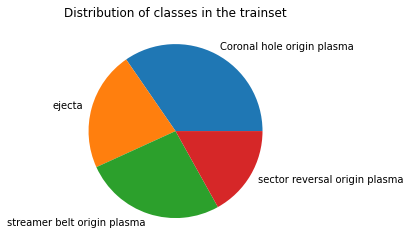

In [10]:
number_coronal_train = 0;
number_ejecta_train = 0;
number_belt_train = 0;
number_revesual_train = 0;
for i, data in enumerate(train_loader_1, 0):
    inputs, labels = data
    labels = Variable(torch.round(3*labels)).type(torch.LongTensor)
    for label in labels:
        if label == 0:
            number_coronal_train = number_coronal_train + 1
        elif label == 1:
            number_ejecta_train = number_ejecta_train + 1
        elif label == 2:
            number_revesual_train = number_revesual_train + 1
        elif label == 3:
            number_belt_train = number_belt_train + 1
class_labels = 'Coronal hole origin plasma', 'ejecta', 'streamer belt origin plasma', 'sector reversal origin plasma'
sizes = [number_coronal_train, number_ejecta_train, number_belt_train, number_revesual_train]
plt.pie(sizes, labels= class_labels)
plt.title("Distribution of classes in the trainset")
plt.show()

We can see that our classes are not perfectly distributed with 'Coronal hole origin plasma' being over-represented and 'sector reversal origin plasma' and 'ejecta' being under-represented a bit. In order to correct these little misrepresenations, we will give the CrossEntropyLoss normed weights ensuring that all classes are equally represented in the loss function.

In [11]:
nSamples = [number_coronal_train, number_ejecta_train, number_revesual_train, number_belt_train]
normedWeights = [1-(x / sum(nSamples)) for x in nSamples]
normedWeights = torch.FloatTensor(normedWeights)

As we chose the CrossEntropyLoss as our loss function, the model will learn to predict the probabilities of the input belonging to the respective classes into this vector with a negative value representing a low probability. In case one would want to get the predicted classes instead, one would search for the index of the maximum value of the output-vector and then find the coressponding category for this index. For example having [-5, 3, -1, -10] as the output vector, the index of the maximum value is 1 and the corresponding category would be "ejectal". A implementation of this is used when evaluating the model in (c).

We will use SGD as an optimizer with the learning rate 1e-3 being a typical choice here.

In [12]:
model = MulticlassClassification(num_feature = 7, num_class = 4)
loss_fn = nn.CrossEntropyLoss(weight = normedWeights)
optimizer = optim.SGD(model.parameters(), lr=0.001)

## Training the model
As we are using CrossEntroyLoss as the LossFunction, we need to assign the labels in format long. Therefore we remap the labels from [0, 0.33, 0.66, 1] to [0, 1 2 3] as we could not represent our 4 classes.

In [13]:
num_epochs = 1000
losses = np.zeros(num_epochs)
model.train()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader_1, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = Variable(torch.round(3*labels)).type(torch.LongTensor)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    if epoch%100 == 99 or epoch == 0:
        print('epoch: %5d loss: %.3f' %(epoch + 1, running_loss))
    losses[epoch] = running_loss
print('Finished Training')

epoch:     1 loss: 21.374
epoch:   100 loss: 7.155
epoch:   200 loss: 5.681
epoch:   300 loss: 5.072
epoch:   400 loss: 4.414
epoch:   500 loss: 4.254
epoch:   600 loss: 3.943
epoch:   700 loss: 3.597
epoch:   800 loss: 3.457
epoch:   900 loss: 3.423
epoch:  1000 loss: 2.984
Finished Training


Plotting the losses over epochs will help us to get an understanding if our model was still improving at the last epoch. With the graph we can answer the following questions and may take reasonable action:
1. can we improve with more iterations? If so, we may increase the number of epochs to improve our model's performance. The downside of this would be a longer training time and higher need for computational resources.
2. did the model run for too many iterations and did not imrpove in the last ones? In this case we could save computational resources and run less epochs.

We can also adapt the learning rate of our optimizer based on the graph. This would be necessary in case the graph is not (monotonously) decreasig (meaning our model is not improving over time). In this case, we would need to decrease the learning rate. When the graph is (monotonously) decreasing and our model is therefore improving over time, we could try to increase the learning rate to make the model improve faster. By increasing the learning rate too much though, we could end up in the first case and our model would not improve over time. Therefore we did not increase the learning rate based on this graph here, but it would be an option for making our model improving faster.

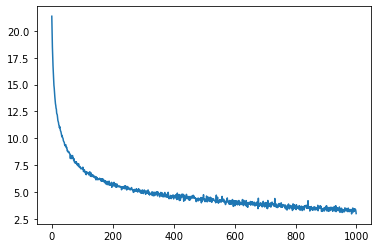

In [14]:
plt.plot(losses)

In our case the learning rate is low enough that the loss is decreasing. We will therefore stay with the chosen learning rate.

Looking at the last part of the graph is seems that we were still improving with more iterations, but not as fast as before. We will therefore stay with the chosen number of epochs, also to prevent that we are overfitting the training data and therefore performing worse on the test data. Here might be room for improvement of the model though by increasing the number of epochs while ensuring that we are not overfitting the training data.

# (c)
As done in the original paper, we have split the data in a train and a test set. We will now run our model on the test set, which the model has not seen before in order to evaluate its performance. We will print the Confusion Matrix as well as the overall accuracy.

In [15]:
samples = 0
correct = 0

number_coronal = 0
correct_coronal = 0
coronal_ejecta = 0
coronal_belt = 0
coronal_revesual = 0

number_ejecta = 0
correct_ejecta = 0
ejecta_coronal = 0
ejecta_belt = 0
ejecta_revesual = 0

number_belt = 0
correct_belt = 0
belt_coronal = 0
belt_ejecta = 0
belt_revesual = 0

number_revesual = 0
correct_revesual = 0
revesual_coronal = 0
revesual_ejecta = 0
revesual_belt = 0

model.eval()
for i, data in enumerate(test_loader_1, 0):
    inputs, labels = data
    labels = Variable(torch.round(3*labels)).type(torch.LongTensor)
    outputs = model(inputs)
    samples = samples + len(labels)
    correct = correct + sum(labels == torch.argmax(outputs, dim=1))
    for i, label in enumerate(labels, 0):
        if label == 0:
            number_coronal = number_coronal + 1
            if torch.argmax(outputs, dim=1)[i] == 0:
                correct_coronal = correct_coronal + 1
            elif torch.argmax(outputs, dim=1)[i] == 1:
                coronal_ejecta = coronal_ejecta + 1
            elif torch.argmax(outputs, dim=1)[i] == 2:
                coronal_belt = coronal_belt + 1
            elif torch.argmax(outputs, dim=1)[i] == 3:
                coronal_revesual = coronal_revesual + 1

        elif label == 1:
            number_ejecta = number_ejecta + 1
            if torch.argmax(outputs, dim=1)[i] == 1:
                correct_ejecta= correct_ejecta + 1
            elif torch.argmax(outputs, dim=1)[i] == 0:
                ejecta_coronal = ejecta_coronal + 1
            elif torch.argmax(outputs, dim=1)[i] == 2:
                ejecta_belt = ejecta_belt + 1
            elif torch.argmax(outputs, dim=1)[i] == 3:
                ejecta_revesual = ejecta_revesual + 1

        elif label == 2:
            number_belt = number_belt + 1
            if torch.argmax(outputs, dim=1)[i] == 2:
                correct_belt = correct_belt + 1
            elif torch.argmax(outputs, dim=1)[i] == 0:
                belt_coronal = belt_coronal + 1
            elif torch.argmax(outputs, dim=1)[i] == 1:
                belt_ejecta = belt_ejecta + 1
            elif torch.argmax(outputs, dim=1)[i] == 3:
                belt_revesual = belt_revesual + 1    

        elif label == 3:
            number_revesual = number_revesual + 1
            if torch.argmax(outputs, dim=1)[i] == 3:
                correct_revesual = correct_revesual + 1
            elif torch.argmax(outputs, dim=1)[i] == 0:
                revesual_coronal = revesual_coronal + 1
            elif torch.argmax(outputs, dim=1)[i] == 1:
                revesual_ejecta = revesual_ejecta + 1
            elif torch.argmax(outputs, dim=1)[i] == 2:
                revesual_belt = revesual_belt + 1  

coronal_performance = np.array([correct_coronal, coronal_ejecta, coronal_belt, coronal_revesual])
ejecta_performance = np.array([ejecta_coronal, correct_ejecta, ejecta_belt, ejecta_revesual])
belt_performance = np.array([belt_coronal, belt_ejecta, correct_belt, belt_revesual])
revesual_performance = np.array([revesual_coronal, revesual_ejecta, revesual_belt, correct_revesual])
performance = np.array([coronal_performance*(100/number_coronal),
                       ejecta_performance*100/number_ejecta,
                       belt_performance*100/number_belt,
                       revesual_performance*100/number_revesual]).astype(np.float)
class_labels_short = ['Coronal hole origin', 'Ejecta', 'Streamer belt origin', 'Sector reversal origin']
df_performance = pd.DataFrame(performance, class_labels_short, class_labels_short)
print("Confusion Matrix")
with pd.option_context('expand_frame_repr', False):
    print(df_performance)
print('Overall Accuracy: ', 100*np.float(correct/samples), '%')

Confusion Matrix
                        Coronal hole origin     Ejecta  Streamer belt origin  Sector reversal origin
Coronal hole origin               99.407817   0.078958              0.078958                0.434268
Ejecta                             0.627353  88.958595              2.823087                7.590966
Streamer belt origin               2.685950   3.925620             79.063361               14.325069
Sector reversal origin             0.159490   2.179692              5.156831               92.503987
Overall Accuracy:  91.47453308105469 %


We can see that that the model in the original papaer was performing better in every observed category with the difference in performance varying heavily between 0.2% for the 'coronal hole origin' category and 18.6% for the 'Streamer belt origin' category. The original paper found that the performance is varying for the different categories, something we also can see in our correlation matrix. Another interesting similarity is that both our and the model from the original paper were performing best on the 'coronal hole origin' category which implies that it can be better seperated from the other categories. For the other categories our results are differing a bit. Especially for the 'Streamer belt origin' category our model is performing much worse than the one from the original paper (79.1% vs. 96.6% true positive).

Using a more complex and deeper ANN and running the training for more epochs, one might be able to close the gap or even perform better than the model in the original paper. This approach was not followed here due to time and performance reasons.